In [69]:
#Python 3.11.2
#Import packages
import scipy.integrate as scipy
import scipy.optimize as optimize
import scipy.stats as stats
import pandas as pd
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import json # for pretty printing

import shutil
import sys
import os.path

In [70]:
climate_data = np.array([[120., 4.835], [210., 15.405], [270., 8.315]
                         , [375., -0.73], [480.,  5.08], [570., 14.945]
                         , [630., 8.58], [735., 1.38], [840., 6.37]
                         , [930., 16.015], [990., 8.065], [1095., 0.29]
                         , [1200.,4.435], [1290., 15.885], [1350., 8.26]
                         , [1455., 0.69], [1560., 2.43], [1650., 14.77]
                         , [1710., 7.795], [1815., 0.56], [1920., 4.17]
                         , [2010., 14.325], [2070., 8.11], [2175., 0.135]
                         , [2280., 6.195], [2370., 14.495], [2430., 8.46]
                         , [2535., -4.24], [2640., 4.335], [2730., 15.35], [2790., 7.1]
                         ])

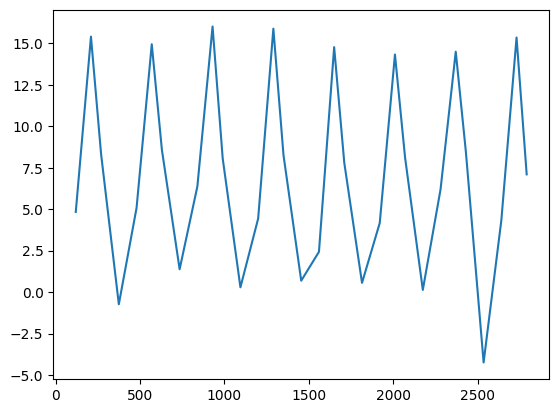

In [71]:
plt.plot(climate_data[:,0], climate_data[:,1])

Select the model

In [72]:
def residuals(parameters, climate_data):
    beta0, beta1, a = parameters
    x = climate_data[:,0] # time
    y = climate_data[:,1] # temperature
    return y - (beta0 + beta1 * np.sin(2 * np.pi * x / 365.25 - a))

Find a best fit

In [73]:
def sos(parameters, climate_data):
    return np.sum(residuals(parameters, climate_data)**2)

def best_fit(fcn, climate_data, disp=1):
    parameter_guess = np.array([6.91, -7.93, -8.07])
    return optimize.fmin(fcn, parameter_guess, args=(climate_data,), disp = disp)

parameter_fit = best_fit(sos, climate_data)

for name,value in zip(['beta0', 'beta1', 'a'], parameter_fit):
    print(name, " = ",  round(value,2))

Optimization terminated successfully.
         Current function value: 145.553338
         Iterations: 62
         Function evaluations: 117
beta0  =  5.89
beta1  =  -7.31
a  =  -7.68


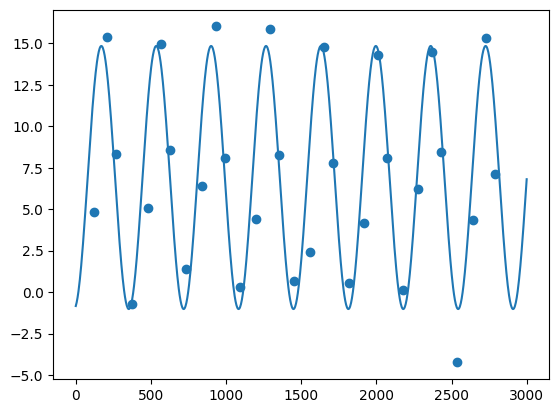

In [74]:
beta0  =  6.91
beta1  =  -7.93
a  =  -8.07
t = np.linspace(0, 3000, 1000)
plt.plot(t,(beta0 + beta1 * np.sin(2 * np.pi * t / 365.25 - a)))
plt.scatter(climate_data[:,0], climate_data[:,1])
pl.show()

Testing the fitting process with a SIR model and synthetic data generated by Mathematica.

S0 =  999.0
I0 =  2.080568554492916
beta =  0.6518262889244687
gamma =  0.4839597935855828


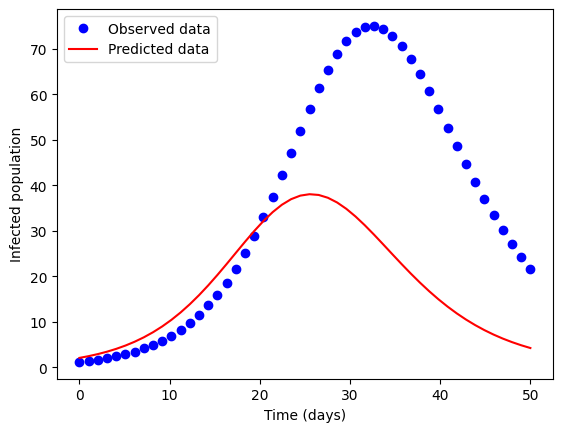

In [83]:
# Define or import the data
data = np.array([1.19646, 1.43109, 1.71112, 2.04506, 2.44293, 2.91644, 3.47919, 
                 4.14694, 4.93776, 5.87222, 6.9734, 8.26688, 9.78045, 11.5436, 
                 13.5864, 15.9384, 18.6265, 21.672, 25.0875, 28.8727, 33.0102, 
                 37.4611, 42.1613, 47.0193, 51.917, 56.7128, 61.2487, 65.3608, 
                 68.8917, 71.7039, 73.6916, 74.7898, 74.9782, 74.2812, 72.7626, 
                 70.5173, 67.6618, 64.3231, 60.6301, 56.7058, 52.6616, 48.5941, 
                 44.5836, 40.6936, 36.9722, 33.4535, 30.1593, 27.1016, 24.284, 21.7042]
                )
# Define the model 
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = - beta * S * I / (S + I + R)
    dI_dt = beta * S * I / (S + I + R) - gamma * I
    dR_dt = gamma * I
    return ([dS_dt, dI_dt, dR_dt])

# Define the objective function to minimize (sum of squared errors)
def objectiveFunction(parameters,  *args):
    S0, I0, beta, gamma = parameters
    y_obseved, time = args
    solution = scipy.odeint(SIR_model, [S0, I0, 0], time, args =(beta,gamma))
    y_predicted = solution[:,1] #only need the infected
    error = np.sum((y_predicted - y_obseved)**2)
    return error

# Set up the data and initial conditions
t = np.linspace(0, len(data)) # assume one time step per day
y_obseved = data # the data we are trying to fit

# Choose initial guesses for the parameters to fit
S0_guess = 999
I0_guess = 1
beta_guess = 0.05
gamma_guess = 0.7

# Minimize the objective function to obtain estimates for S0, I0, beta and gamma
result = optimize.minimize(objectiveFunction, [S0_guess, I0_guess, beta_guess, gamma_guess], args=(y_obseved,t), method='L-BFGS-B', bounds=[(0, 1000), (0, 1000), (0, 2), (0, 2)])
S0_estimated, I0_estimated, beta_estimated, gamma_estimated = result.x

print("S0 = ", S0_estimated)
print("I0 = ", I0_estimated)
print("beta = ", beta_estimated)
print("gamma = ", gamma_estimated)


#Plot the obseved data
plt.plot(t, y_obseved, 'bo', label='Observed data')

#Plot the predicted values from the SIR model using the estimated parameters
y_predicted = scipy.odeint(SIR_model, [S0_estimated, I0_estimated,0], t, args =(beta_estimated,gamma_estimated))
plt.plot(t, y_predicted[:,1], 'r-', label='Predicted data')

#Add labels and legend
plt.xlabel('Time (days)')
plt.ylabel('Infected population')
plt.legend()

#Show the plot
plt.show()